<a href="https://colab.research.google.com/github/Tasfia48/CS584/blob/main/HW2_Mashiat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Team Name: "chi"
* Rank: 128
* Accuracy: 0.67

Goal:
My goal for this homework was to develop predictive models that can determine given a particular individual whether their credit risk is high or low. I compared different binary classification models based on F1 score and determined the best model.

In [ ]:
#Load the necessary python libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler as UnderSampler
from imblearn.over_sampling import RandomOverSampler as OverSampler

### Load Data
Initially, I load the data from the train and test files and store them in separate dataframes. The training dataset is in Train and testing dataset is in Test.

In [ ]:
#Loading training and testing data
Train = pd.read_csv('1600106342_882043_train.csv')
Test = pd.read_csv('1600106342_8864183_test.csv')

Data Exploration

In [ ]:
# first five rows of train-data
Train.head(5)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,credit
0,0,13,40,1,1,2174,0,4,7,9,White,Male,0
1,1,13,13,0,4,0,0,2,6,9,White,Male,0
2,2,9,40,1,6,0,0,0,4,11,White,Male,0
3,3,7,40,0,6,0,0,2,4,1,Black,Male,0
4,4,13,40,5,10,0,0,2,4,9,Black,Female,0


In [ ]:
# first five rows of test-data
Test.head(5)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11
0,0,7,40,3,7,0,0,4,4,1,Black,Male
1,1,12,40,0,11,0,0,2,2,7,White,Male
2,2,10,40,0,7,7688,0,2,4,15,Black,Male
3,3,10,30,3,0,0,0,4,0,15,White,Female
4,4,6,30,1,8,0,0,4,4,0,White,Male


In [ ]:
print("Columns in Training Dataset",Train.columns)

Columns in Training Dataset Index(['id', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10',
       'F11', 'credit'],
      dtype='object')


Text(0.5, 1.0, 'Correlation Matrix for Training Dataset')

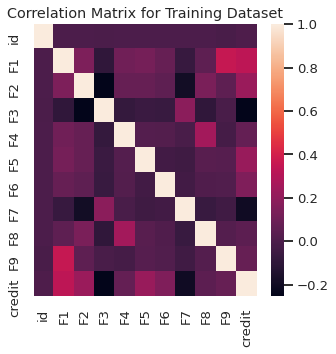

In [ ]:
corr= Train.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)
plt.title('Correlation Matrix for Training Dataset')

From the correlation matrix we can see that some of the feature has negative correlation with the target variable Credit. But I will keep all of the feature and do further exploration.

In [ ]:
#['F3', 'F4', 'F7', 'F8', 'F9', 'F10','F11'] columns represents catagorical values
#['F1','F2','F5','F6'] columns represents numeric data
# 'id' column is not used in classification. So I dropped 'id'.
Train = Train.drop(["id"],axis=1)
Test = Test.drop(["id"],axis=1)
#Our target variable is 'credit'.Credit risk is high denoted by 0 or low denoted by1.
target = 'credit'

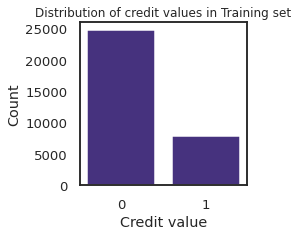

In [ ]:
Count=Train.groupby('credit').count()
plt.figure(figsize=(3,3))
plt.bar(Count.index.values, Count['F1'])
plt.xlabel('Credit value')
plt.ylabel('Count')
plt.xticks([0,1])
plt.title("Distribution of credit values in Training set",fontsize=12)
plt.show()

From Fig 1 we can see that there are 24720 rows with credit =0 and 7841 rows with credit = 1 in the training dataset. Which implies that the dataset is imbalanced. Target label has different distribution. 

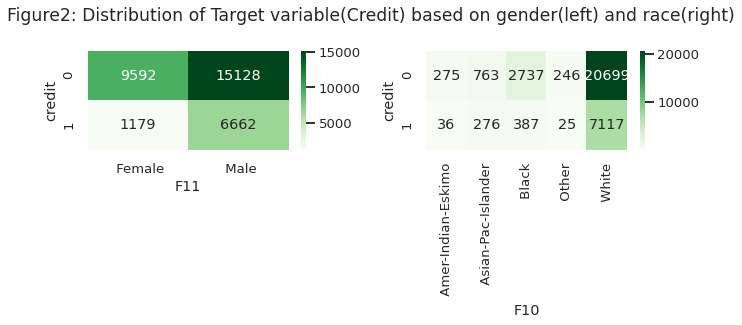

In [ ]:
temp = Train.groupby(['credit','F11'])['F1'].count().reset_index(name="freq")
piv = pd.pivot_table(temp, values='freq',index=["credit"], columns=["F11"], fill_value=0)
temp1 = Train.groupby(['credit','F10'])['F1'].count().reset_index(name="freq")
piv1 = pd.pivot_table(temp1, values='freq',index=["credit"], columns=["F10"], fill_value=0)
#plot pivot table as heatmap using seaborn
fig, ax = plt.subplots(ncols=2, figsize=(10,3))
fig. tight_layout(pad=3.0)
fig.suptitle('Figure2: Distribution of Target variable(Credit) based on gender(left) and race(right)')
sns.heatmap(piv,annot=True,cmap="Greens", fmt="d",ax=ax[0])
sns.heatmap(piv1,annot=True,cmap="Greens", fmt="d",ax=ax[1])
plt.show()

Figure 2 showes ditribution of target variable accross different gender and races.
### Data Pre-processing

In [ ]:
# Replacing catagorial values with dummy variables
cat = ['F3', 'F4', 'F7', 'F8', 'F9', 'F10','F11']
Train = pd.get_dummies(Train, columns=['F3', 'F4', 'F7', 'F8', 'F9', 'F10','F11'])
Test = pd.get_dummies(Test, columns=['F3', 'F4', 'F7', 'F8', 'F9', 'F10','F11'])  
# standardizing numeric columns for better prediction
num = ['F1','F2','F5','F6']
for attr in num:
  Train[attr] = (Train[attr]-Train[attr].mean())/Train[attr].std()
  Test[attr] = (Test[attr]-Test[attr].mean())/Test[attr].std()

In [ ]:
#after handling the catagorical and numric features. The Train dataset has 65 dimensions
len(Train.columns)

65

It is very difficult to visualize 65 dimensional data. So I am using Principal Component Analysis (PCA) to visulaize the data points based on the two values of the target variable. I have reduced the Train data set into two dimensions, PC1 and PC2.


In [ ]:
def pca_plot(X, y,title):
    pca = PCA(n_components = 2)
    X_pc = pca.fit_transform(X)    
    fig, ax = plt.subplots(figsize=(4,4))
    mask = y==0
    ax.scatter(X_pc[mask, 0], X_pc[mask, 1], color='#1f77b4', label='Credit 0', alpha=0.5 ,s=20)
    ax.scatter(X_pc[~mask, 0], X_pc[~mask, 1], color='#ff7f0e', label='Credit 1', alpha=0.5 ,s=20)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(loc='best')
    plt.title(title,fontsize=12)
    return X_pc

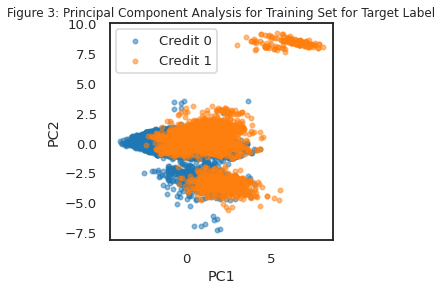

In [ ]:
dfTrain = Train.copy()
labels = np.array(dfTrain.pop('credit'))
X_pc = pca_plot(dfTrain, labels,"Figure 3: Principal Component Analysis for Training Set for Target Label")

From PCA plot, we can see that there is some outlier data in the training data set. I removed the outliers from the training dataset

In [ ]:
pca = pd.DataFrame(X_pc,columns=['PC1','PC2'])
pca['y'] = labels
index = pca[pca.PC2>5].index
ChangedTrain = Train.copy()
ChangedTrain=ChangedTrain.drop(index)
dropedTrain = ChangedTrain.copy()
ChangedLabel = np.array(ChangedTrain.pop('credit'))

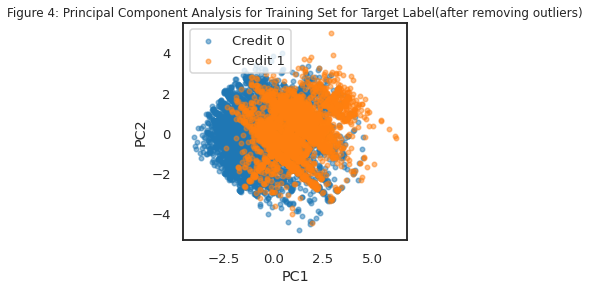

In [ ]:
t= pca_plot(ChangedTrain,ChangedLabel,"Figure 4: Principal Component Analysis for Training Set for Target Label(after removing outliers)")

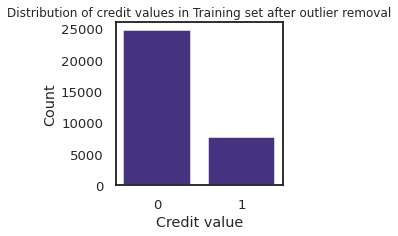

In [ ]:
Count=dropedTrain.groupby('credit').count()
plt.figure(figsize=(3,3))
plt.bar(Count.index.values, Count['F1'])
plt.xlabel('Credit value')
plt.ylabel('Count')
plt.xticks([0,1])
plt.title("Distribution of credit values in Training set after outlier removal",fontsize=12)
plt.show()

### Handling Imbalanced Dataset
Even after removing the outliers the data is not equally distributed for both of the class value. To balance the dataset, we will resample data in two ways:
*   Over Sampling
*   Under Sampling

I will use logistic regression as my baseline model to compare the f1 score for over-sampled and under-sampled data


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


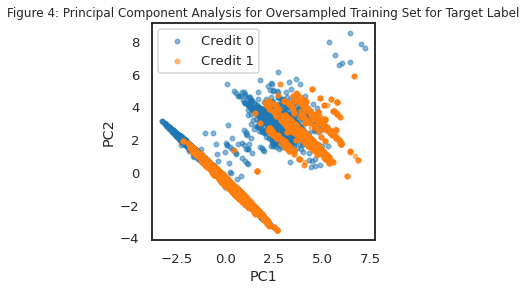

In [ ]:
#Over Sampling
os = OverSampler()
X_up, y_up = os.fit_sample(ChangedTrain, ChangedLabel)
fig = pca_plot(X_up, y_up,"Figure 4: Principal Component Analysis for Oversampled Training Set for Target Label")

In [ ]:
print("number of records with credit 1 =",np.count_nonzero(y_up))
print("number of records with credit 0 =",len(y_up)-np.count_nonzero(y_up))

number of records with credit 1 = 24720
number of records with credit 0 = 24720


In [ ]:
train, test, train_labels, test_labels = train_test_split(X_up,y_up,test_size = 0.2, random_state = 123)
clf =LogisticRegression(solver='liblinear')
clf.fit(train,train_labels)
ypred = clf.predict(test)
print('f1 score for logistic regression on oversampled data',f1_score(test_labels,ypred))

f1 score for logistic regression on oversampled data 0.8226216057823794


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


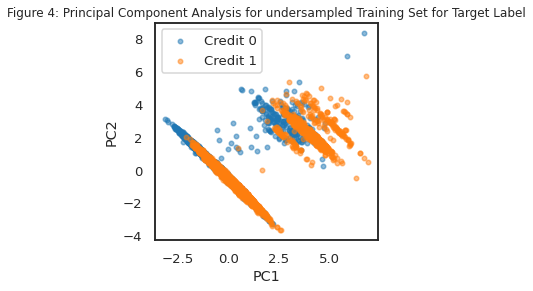

In [ ]:
#Under-sampling
us = UnderSampler()
X_dn, y_dn = us.fit_sample(ChangedTrain, ChangedLabel)
fig = pca_plot(X_dn, y_dn,"Figure 4: Principal Component Analysis for undersampled Training Set for Target Label")

In [ ]:
print("number of records with credit 1 =",np.count_nonzero(y_dn))
print("number of records with credit 0 =",len(y_dn)-np.count_nonzero(y_dn))

number of records with credit 1 = 7682
number of records with credit 0 = 7682


In [ ]:
train, test, train_labels, test_labels = train_test_split(X_dn,y_dn,test_size = 0.2, random_state = 123)
clf =LogisticRegression(solver='liblinear')
clf.fit(train,train_labels)
ypred = clf.predict(test)
print('f1 score for logistic regression on oversampled data',f1_score(test_labels,ypred))

f1 score for logistic regression on oversampled data 0.8246852932146148


From the f1 scores for logictic regression, it can be seen that the undersampled data scored better then the oversampled data, and it also solves the imbalance dataset problem. As now for both of the target values there is equal number of records.So, I will use the undersampled data to compare among different binary classification models which one will provide the best score for this dataset.
### Binary classifier Selection
Intially, I compared LogisticRegression, RandomForestClassifier, and support vector classifier. I calculated the mean f1_Score for 5-fold cross validation using the undersampled dataset.

In [ ]:
from sklearn import svm
lr = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=50)
sv = svm.SVC()
lr_scores = cross_val_score(lr, X_dn, y_dn, cv=5, scoring='f1')
rfc_scores = cross_val_score(rfc, X_dn, y_dn, cv=5, scoring='f1')
sv_scores = cross_val_score(sv, X_dn, y_dn, cv=5, scoring='f1')
print('LR Scores: ', lr_scores.mean())
print('RFC Scores: ', rfc_scores.mean())
print('SVC scores: ', sv_scores.mean())

LR Scores:  0.8233405771481108
RFC Scores:  0.8048468269589681
SVC scores:  0.8267685778583258


From the results, it looks like SVC performed better than logistic regression and random forest classfier. For futher investigation, I tuned the hyper parameters for each of the classifiers.


In [ ]:
#Logistic Regression
train, test, train_labels, test_labels = train_test_split(X_dn,y_dn,test_size = 0.2, random_state = 123)
param_test = {
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear']
}
gsearchLR = GridSearchCV(estimator =LogisticRegression(),param_grid = param_test, scoring='f1',n_jobs=-1, cv=5)

train_modelLR = gsearchLR.fit(train, train_labels)
pred4 = train_modelLR.predict(test)
print("f1 score for LogisticRegression : %.2f" % (f1_score(test_labels, pred4) ))

f1 score for LogisticRegression : 0.82


In [ ]:
#Random Forest
param_test = {
    'n_estimators': [20,50,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['None','balanced','balanced_subsample']
}
gsearchRF = GridSearchCV(estimator =RandomForestClassifier(n_jobs=-1,max_features= 'auto',class_weight=None ,n_estimators=20, oob_score = True), 
 param_grid = param_test, scoring='f1',n_jobs=-1, cv=5)

train_modelRF = gsearchRF.fit(train, train_labels)
pred4 = train_modelRF.predict(test)
print("f1 score for Random Forest : %.2f" % (f1_score(test_labels, pred4) ))

f1 score for Random Forest : 0.82


In [ ]:
# Support Vector Classifier
sv = svm.SVC()
param_test = {
              'C': [.1, 1, 100, 1000],
              'gamma': [0.001, 0.01, .1],
              'kernel': ['rbf', 'sigmoid']
              }
gsearch = GridSearchCV(estimator =sv,param_grid = param_test, scoring='f1',cv=5)

train_modelSVC = gsearch.fit(train, train_labels)
pred4 = train_modelSVC.predict(test)
print("f1 score for SVC: %.2f" % (f1_score(test_labels, pred4) ))

f1 score for SVC: 0.83


In [ ]:
print(gsearch.best_estimator_)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


After tuning hyper parameters, still SVC performs better than Random forest and Logistic Regression. I tested the results in Miner for the test data set and the result was 0.65.


In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
param_test = {
              'criterion': ['gini', 'entropy']
              }
gsearchDT = GridSearchCV(estimator= DecisionTreeClassifier(random_state=42),param_grid = param_test, scoring='f1',cv=5)
train_modelDT = gsearchDT.fit(train, train_labels)
predDT = train_modelDT.predict(test)
print("f1 score for SVC: %.2f" % (f1_score(test_labels, predDT) ))               

f1 score for SVC: 0.80


In [ ]:
#Naive Bayes
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score 
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
RNG = 42
scv = StratifiedKFold(n_splits=5)
clf = GaussianNB()
score1 = cross_val_score(clf, X_dn, y_dn, scoring='f1', cv=scv).mean()
print('f1 score for Naive Bayes', score1)

f1 score for Naive Bayes 0.7679489278724468


For the dataset, I implemented Naive Bayes, and DecisionTreeClassifier also but the svm result better them both of them. Next I will apply XGBoost Classifier.XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.




In [ ]:
#XGBoost
train, test, train_labels, test_labels = train_test_split(X_dn,y_dn,test_size = 0.2, random_state = 123)
param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearchXG = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring='f1',n_jobs=4, cv=5)
train_modelXG = gsearchXG.fit(train, train_labels)
ypred = train_modelXG.predict(test)
print("f1 score for XGBoost model: %.2f" % (f1_score(test_labels, ypred) ))

f1 score for XGBoost model: 0.84


The f1 score for XGBoost was better than SVC. So, I used XGBosst to predict for the test dataset. In Miner was, 0.67 for XGBoost.

In [ ]:
predicted = train_modelXG.predict(Test.values)
with open('format.txt', 'w') as filehandle:
    for listitem in predicted:
        filehandle.write('%s\n' % listitem)

### Checking f1 scores for different genders and races

In [ ]:
def plotConfuionMatrix(df_cm,ax,title):
  sns.heatmap(df_cm, annot=True,ax=ax)
  ax.set_xlabel("Predicted", fontsize=14)
  ax.set_ylabel('True', fontsize=14)
  ax.set_title(title)

In [ ]:
def ConfuionMatrixLR(column,Train):
  male = Train[Train[column]==1]
  male = male.drop(['credit'],axis=1)
  y_true = Train[Train[column]==1]['credit']
  y_pred = train_modelLR.predict(male.values)
  C = confusion_matrix(y_true, y_pred)
  C=C / C.astype(np.float).sum(axis=1)
  df_cm = pd.DataFrame(C, index = [i for i in (0,1)],columns = [i for i in (0,1)])
  return df_cm

In [ ]:
def ConfuionMatrixXG(column,Train):
  male = Train[Train[column]==1]
  male = male.drop(['credit'],axis=1)
  y_true = Train[Train[column]==1]['credit']
  y_pred = train_modelXG.predict(male.values)
  C = confusion_matrix(y_true, y_pred)
  C=C / C.astype(np.float).sum(axis=1)
  df_cm = pd.DataFrame(C, index = [i for i in (0,1)],columns = [i for i in (0,1)])
  return df_cm

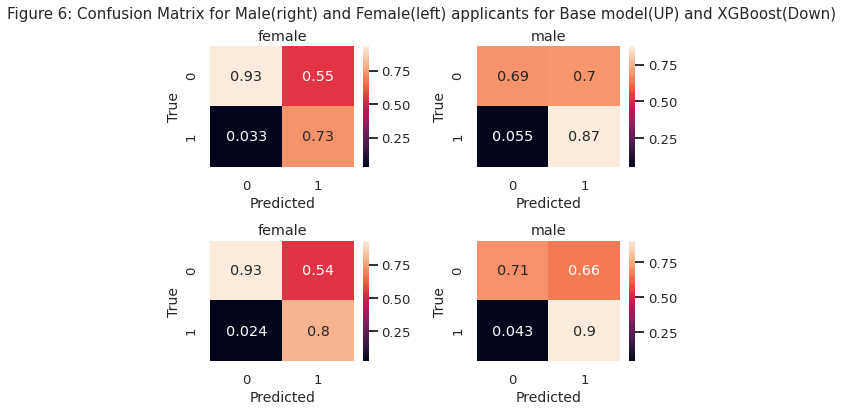

In [ ]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(8,6))
fig. tight_layout(pad=3.0)
fig.suptitle('Figure 6: Confusion Matrix for Male(right) and Female(left) applicants for Base model(UP) and XGBoost(Down)',fontsize=15)
a = ConfuionMatrixLR('F11_ Female',Train)
plotConfuionMatrix(a,ax[0][0],'female')
b = ConfuionMatrixLR('F11_ Male',Train)
plotConfuionMatrix(b,ax[0][1],'male')
c = ConfuionMatrixXG('F11_ Female',Train)
plotConfuionMatrix(c,ax[1][0],'female')
d = ConfuionMatrixXG('F11_ Male',Train)
plotConfuionMatrix(d,ax[1][1],'male')
plt.show()

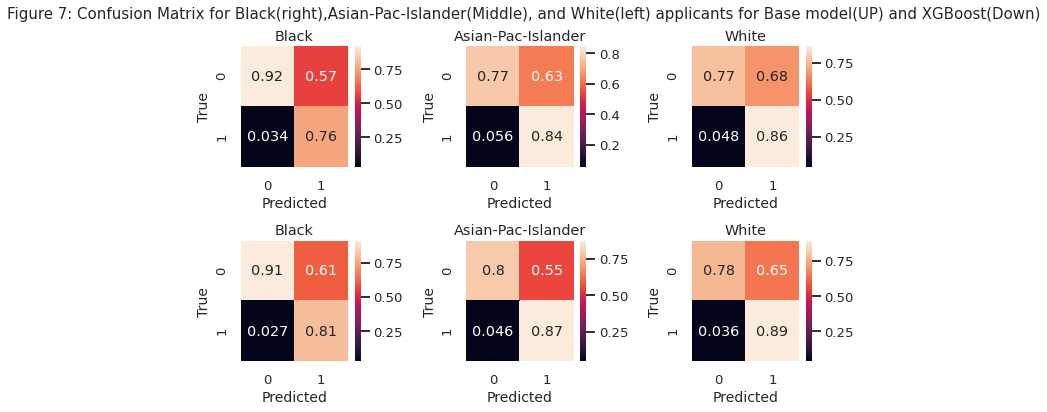

In [ ]:
fig, ax = plt.subplots(ncols=3,nrows=2, figsize=(10,6))
fig. tight_layout(pad=3.0)
fig.suptitle('Figure 7: Confusion Matrix for Black(right),Asian-Pac-Islander(Middle), and White(left) applicants for Base model(UP) and XGBoost(Down)',fontsize=15)
a = ConfuionMatrixLR('F10_ Black',Train)
plotConfuionMatrix(a,ax[0][0],'Black')
b = ConfuionMatrixLR('F10_ Asian-Pac-Islander',Train)
plotConfuionMatrix(b,ax[0][1],'Asian-Pac-Islander')
c = ConfuionMatrixLR('F10_ White',Train)
plotConfuionMatrix(c,ax[0][2],'White')
e = ConfuionMatrixXG('F10_ Black',Train)
plotConfuionMatrix(e,ax[1][0],'Black')
f = ConfuionMatrixXG('F10_ Asian-Pac-Islander',Train)
plotConfuionMatrix(f,ax[1][1],'Asian-Pac-Islander')
g = ConfuionMatrixXG('F10_ White',Train)
plotConfuionMatrix(g,ax[1][2],'White')
plt.show()

From figure 6 and 7, we can see that both XGBoost model performed better for most of the cases then the baseline model(logistic Regression) other then the race Black all of the race has better prediction. There might be some bias in for race Black applicants.

In [ ]:
#Prediction using single layer perceptron
def perceptron(data, num_iter):
    features = data[:, :-1]
    labels = data[:, -1]
    w = np.zeros(shape=(1, features.shape[1]+1))  
    for epoch in range(num_iter):
        for x, label in zip(features, labels):
            x = np.insert(x,0,1)
            y = np.dot(w, x.transpose())
            target = 1.0 if (y > 0) else 0.0            
            delta = (label.item(0,0) - target)            
            if(delta):
                w += (delta * x)
    return (w)

In [ ]:
def predict(row, weights):
  # print(len(row),len(weights))
  activation = weights[0]
  for i in range(len(row)-1):
    activation += weights[i + 1] * row[i]
  return 1.0 if activation >= 0.0 else 0.0

In [ ]:
data = dropedTrain.copy()
data = data.drop(columns={'credit'})
data['credit'] = dropedTrain['credit']
def load_data(data):
    data = np.asmatrix(data, dtype = 'float64')
    return data
data = load_data(dropedTrain)
final = dropedTrain.copy()
final = final.drop(columns={'credit'})
final['credit'] = dropedTrain['credit']

In [ ]:
w=perceptron(data,10)
predictedCredit =[]
for row in final.values:
  prediction = predict(row, w[0])
  predictedCredit.append(prediction)
print('f1_score for single layer perceptron',f1_score(final.credit.values,predictedCredit)) 

f1_score for single layer perceptron 0.1255697851096158


The f1 score for single layer perceptron was very poor. So from all of the experiments, I reach to the conclusion that, XGBoost performed better for this classification problem based on F1 score.